In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker


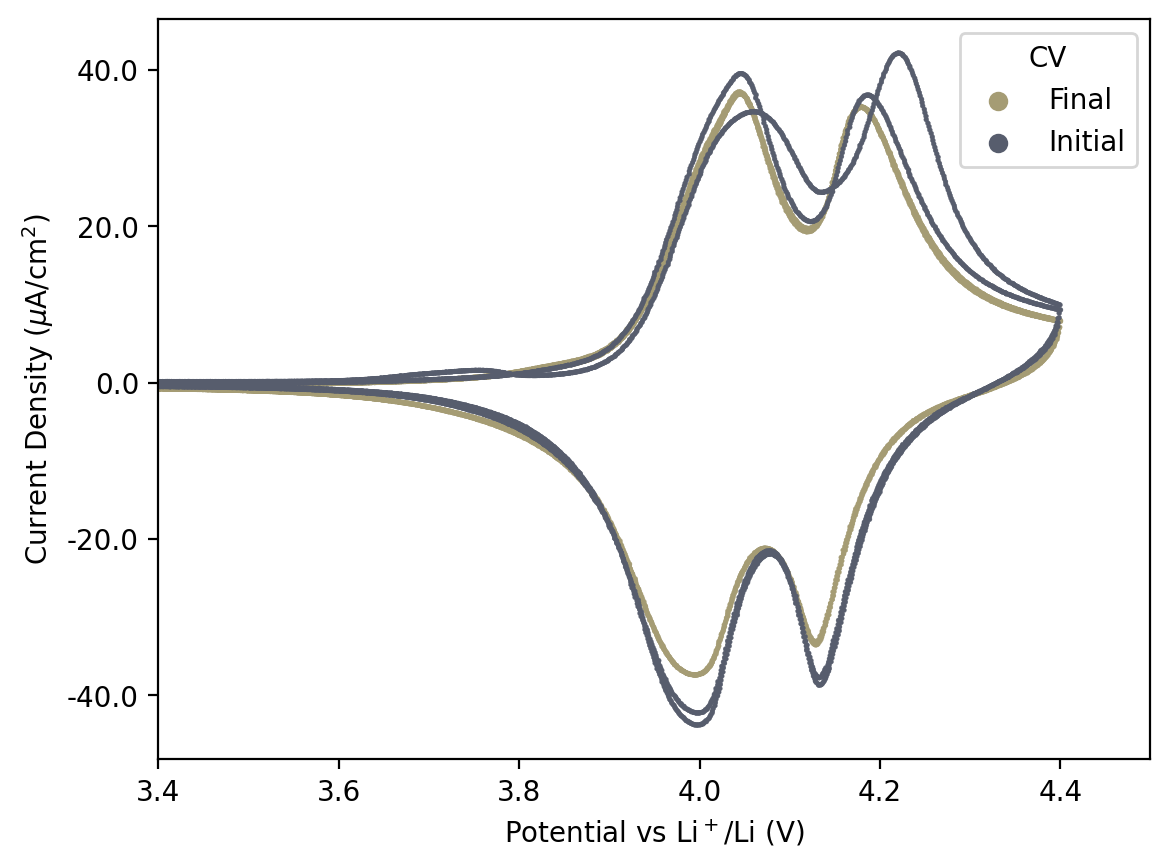

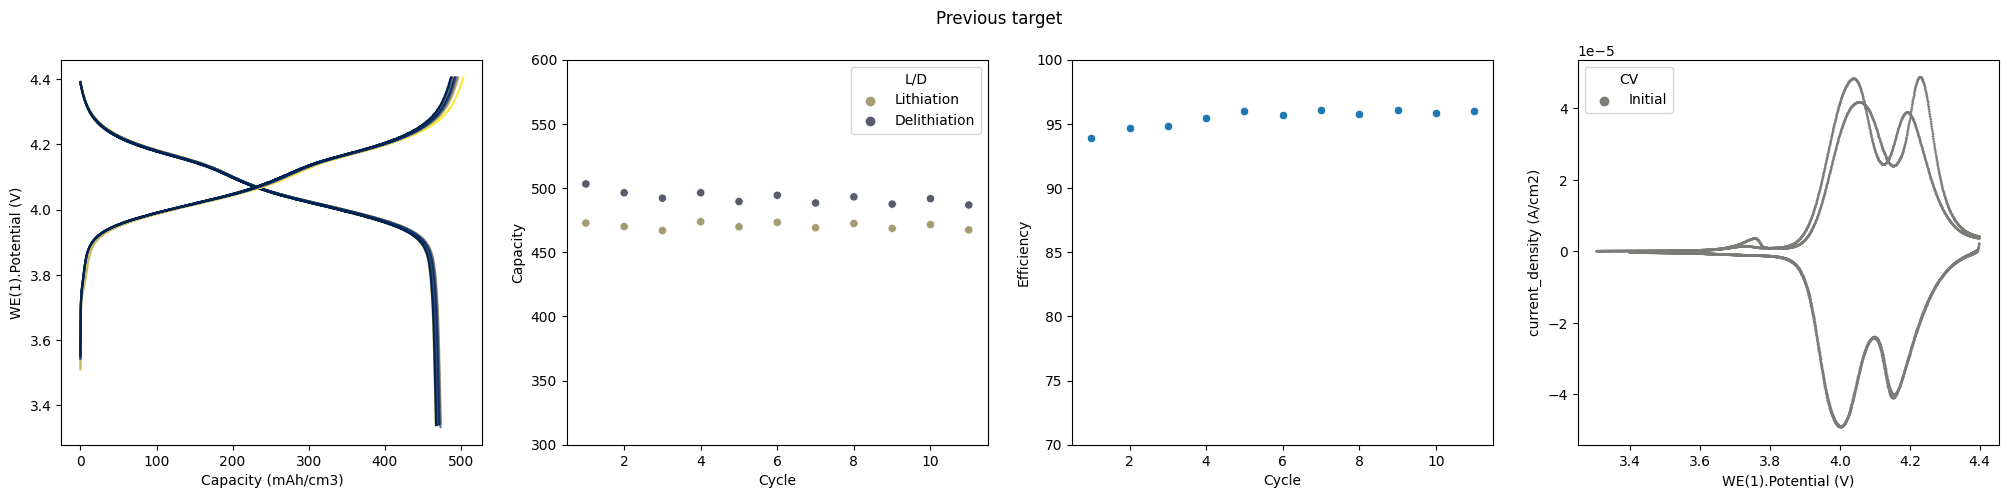

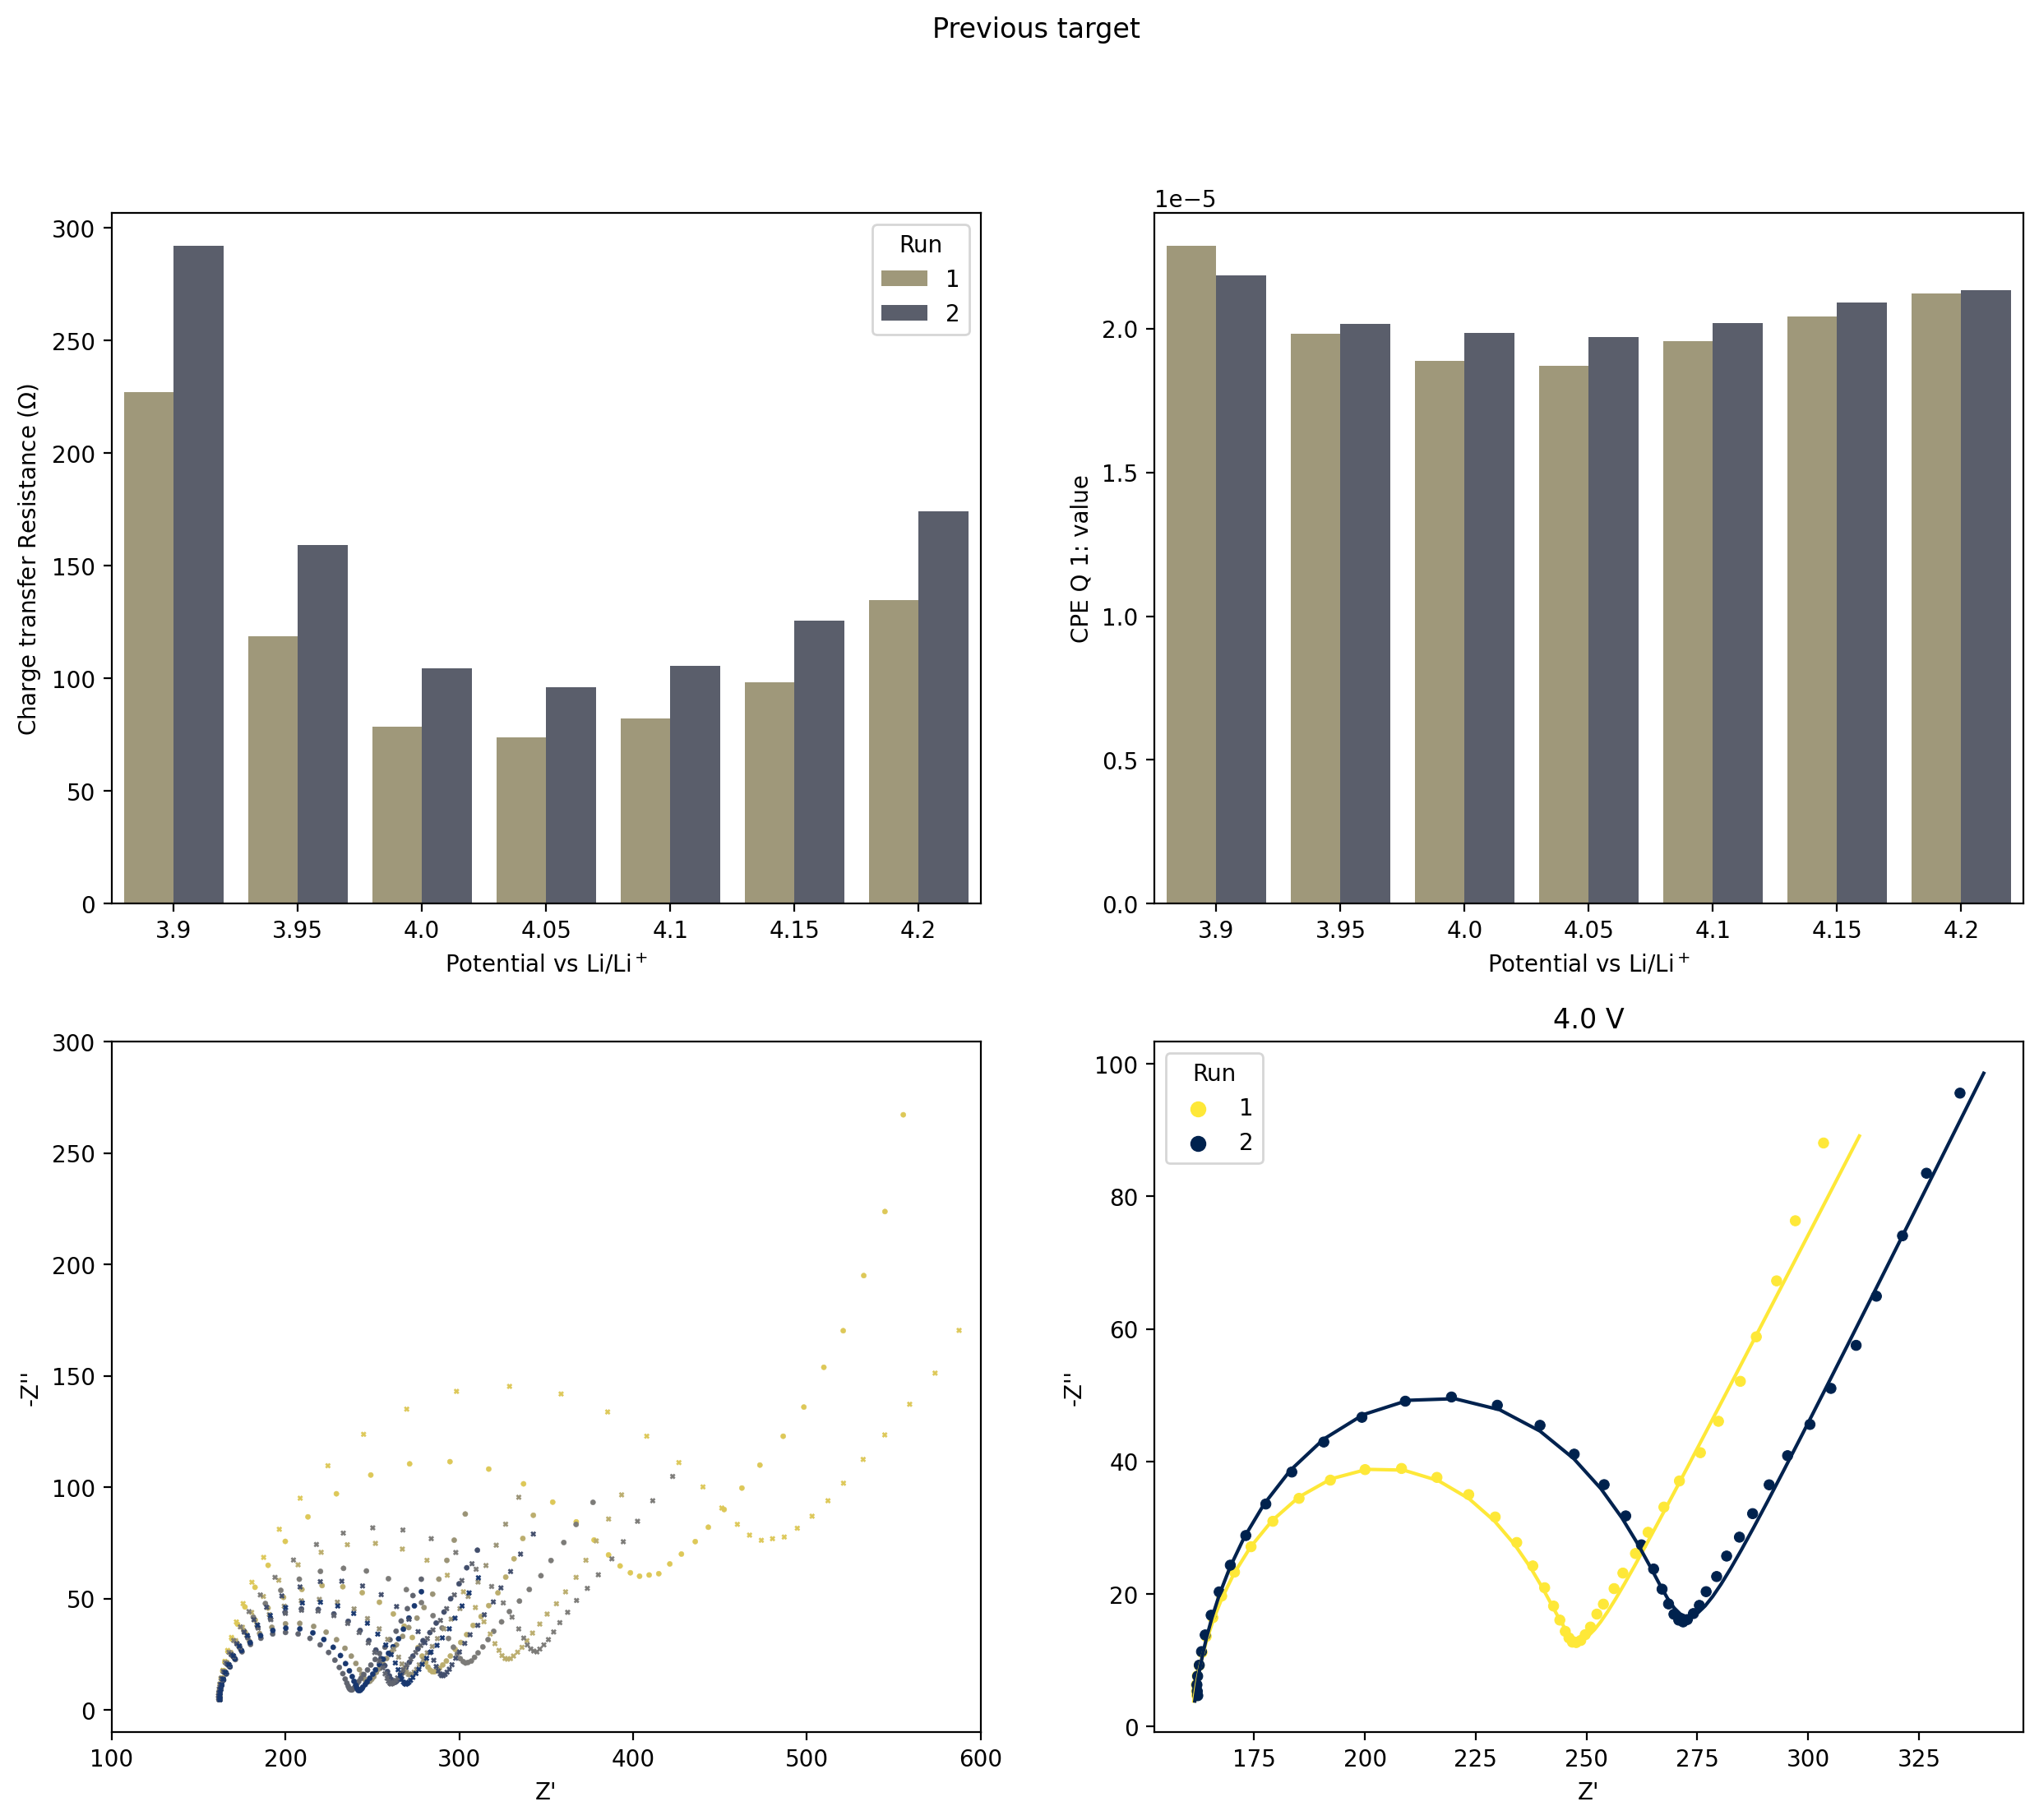

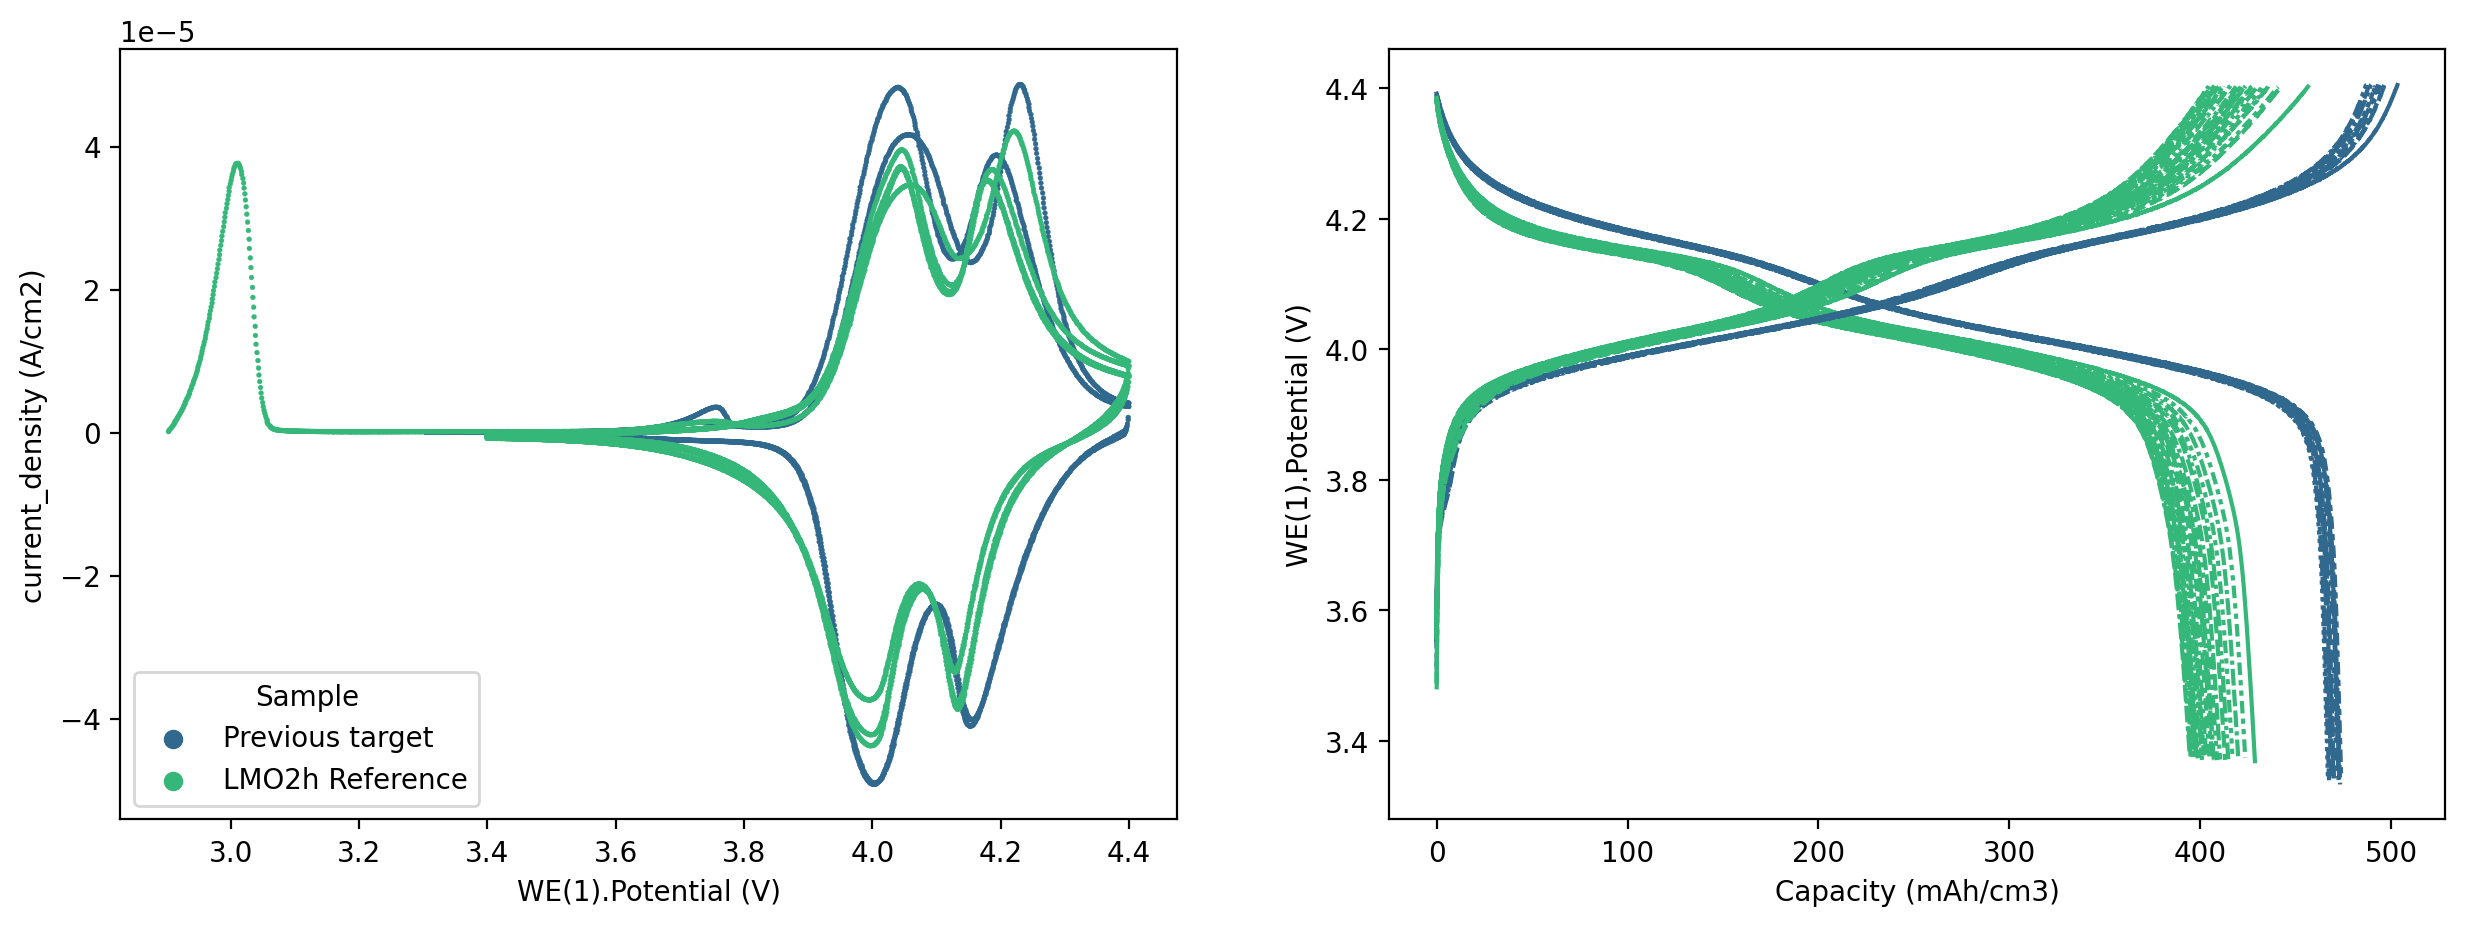

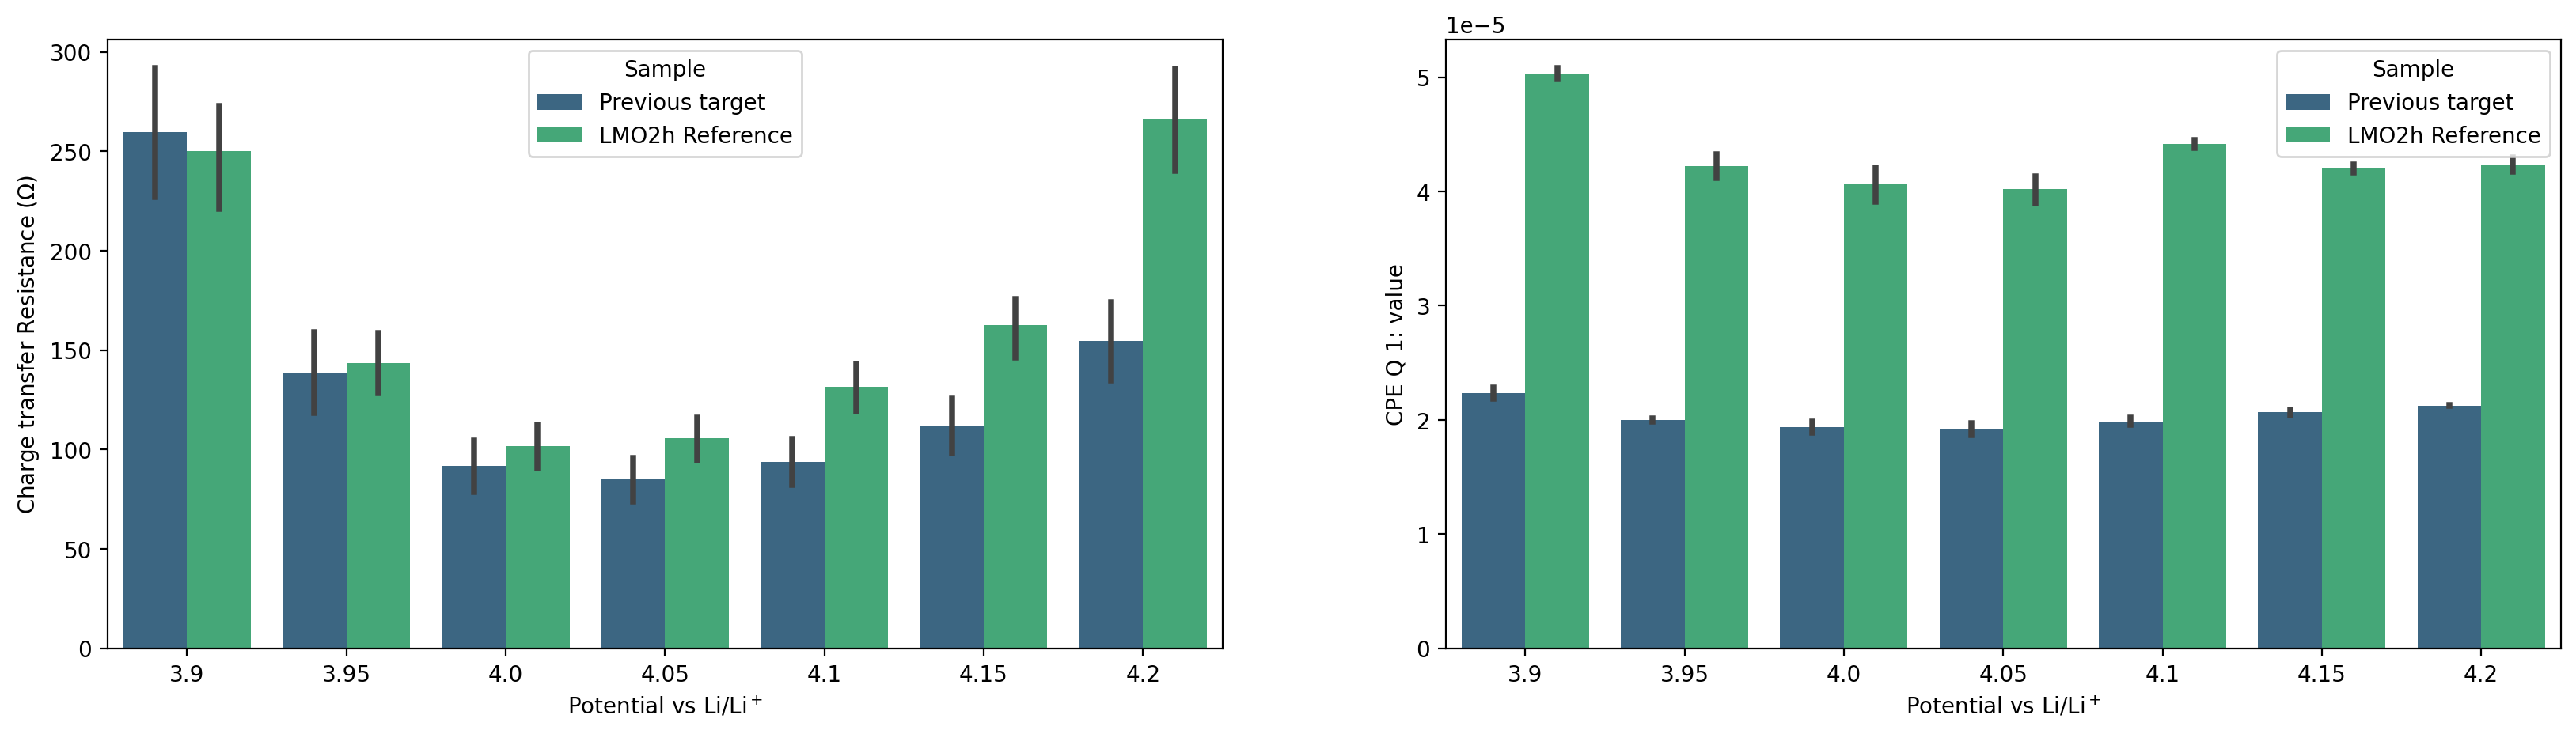

In [ ]:
# import data
%run LESK32.ipynb

In [ ]:
# Methods

col_dep = ['Time (s)', 'Potential vs Ag/AgCl (V)', 'Current (A)', 'Charge (C)']
col_cv = ['Potential vs Li$^+$/Li (V)', 'Current (A)', 'Charge (C)', 'Time (s)', 'Current Density ($\mu$A/cm$^2$)', 'Scan']
potentials = ['{:.2f}'.format(round(i, 4))  for i in np.arange(3.90, 4.20, 0.05)]
formatter_0 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e3))
formatter = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e6))
palette = 'cividis_r'


In [ ]:
# Set up files

def setup_files(path):

    files = [os.path.join(path, i) for i in os.listdir(path)]
    folders = ['CV', 'lith', 'delith', 'EIS']
    
    for i in folders:
        if not os.path.exists(os.path.join(path, i)):
            os.mkdir(os.path.join(path, i))

    if not os.path.exists(os.path.join(path, 'EIS', 'Relaxis')):
        os.mkdir(os.path.join(path, 'EIS', 'Relaxis'))
        
    for i in os.listdir(path):
        if 'EIS_' in i:
            os.rename(os.path.join(path, i), os.path.join(path, 'EIS', i))
            
    for i in os.listdir(os.path.join(path, 'EIS')):
        if 'relaxis' in i:
            os.rename(os.path.join(path, 'EIS', i), os.path.join(path, 'EIS', 'Relaxis', i))

    for i in os.listdir(path):
        if '_lith_' in i:
            os.rename(os.path.join(path, i), os.path.join(path, 'lith', i))
        elif '_delith' in i:
            os.rename(os.path.join(path, i), os.path.join(path, 'delith', i))
        elif i != 'README.txt' and len(i) > 7:
            os.rename(os.path.join(path, i), os.path.join(path, 'CV', i))
            
    for file_path in [os.path.join(os.path.join(path, 'EIS', 'Relaxis'), i) for i in os.listdir(os.path.join(path, 'EIS', 'Relaxis'))]:
        # Extract the directory and filename from the file path
        directory, filename = os.path.split(file_path)
        
        # Extract the numeric part from the filename (assuming it's the last part before '_relaxis.txt')
        numeric_part = filename.split('_relaxis.txt')[0].split('EIS_')[-1]
        
        # Convert the numeric part to a float and format it to have 2 decimals
        numeric_with_two_decimals = '{:.2f}'.format(float(numeric_part))
        
        # Create the new filename by replacing the numeric part
        new_filename = filename.replace(numeric_part, numeric_with_two_decimals)
        
        # Create the new file path
        new_file_path = os.path.join(directory, new_filename)
    
        # # Rename the file
        if file_path != new_file_path:
            
            os.rename(file_path, new_file_path)
            print(f"Renamed: {file_path} => {new_file_path}")
       
def cc(path, area, thickness, sample):

    cv_path = os.path.join(path, 'CV')
    lith_path = os.path.join(path, 'lith')
    delith_path = os.path.join(path, 'delith')
    cv_df = pd.DataFrame()
    
    for i in os.listdir(cv_path):
        f = os.path.join(cv_path, i)
        df = pd.read_csv(f, sep = ';', skiprows = 1, names = col_cv)
        if '_Initial_' in i:
            df['CV'] = 'Initial'
        else:
            df['CV'] = 'Final'
        cv_df = pd.concat([cv_df, df], ignore_index=True)
        
    lithiation = pd.DataFrame()
    delithiation = pd.DataFrame()
    capacity_l = pd.DataFrame(columns = ['Capacity (mAh/cm$^3$)', 'Cycle', 'L/D'])
    capacity_d = pd.DataFrame(columns = ['Capacity (mAh/cm$^3$)', 'Cycle', 'L/D'])
    
    l = [os.path.join(lith_path, i) for i in os.listdir(lith_path)]
    n = 1
    for i in l:
        df = pd.read_csv(i, sep = ';')
        df = df.rename(columns={'WE(1).Potential (V)': col_cv[0], 'Capacity (mAh/cm3)': 'Capacity (mAh/cm$^3$)'})
        # df['Set'] = i[-1]
        df['Cycle'] =  n #str(n) ### string or int
        df['Capacity_calc'] = -df['WE(1).Charge (C)'] /3.6 / (area * 1e-7 * thickness)
        lithiation = pd.concat([lithiation, df], ignore_index=True)
        capacity_l.loc[n] = (max(df['Capacity_calc']), n, 'Lithiation')
        n += 1
    
    d = [os.path.join(delith_path, i) for i in os.listdir(delith_path)]
    n = 1
    for i in d:
        df = pd.read_csv(i, sep = ';')
        df = df.rename(columns={'WE(1).Potential (V)': col_cv[0], 'Capacity (mAh/cm3)': 'Capacity (mAh/cm$^3$)'})
        # df['Set'] = i[-1]
        df['Cycle'] =  n #str(n) ### string or int
        df['Capacity_calc'] = df['WE(1).Charge (C)'] /3.6 / (area * 1e-7 * thickness)
        delithiation = pd.concat([delithiation, df], ignore_index=True)
        capacity_d.loc[n] = (max(df['Capacity_calc']), n, 'Delithiation')
        n += 1
        
    capacity = pd.concat([capacity_l, capacity_d], ignore_index=True)
    

    # ###
    results = [cv_df, lithiation, delithiation, capacity]#, efficiency]
    for i in results:
        i['Sample'] = sample
    # ###
    return results#results #cv_df, lithiation, delithiation, capacity, efficiency

def eis(path, sample):
    
    col = ["Frequency (Hz)", "Z'", "-Z''", "Fit Frequency (Hz)", "Fit Z'", "Fit -Z''" ]
    
    files = [os.path.join(path, i) for i in os.listdir(path)]
    eis_data = pd.DataFrame()
    spectra = pd.DataFrame()
    m = 0
    for i in files:
        if 'Fit' in i:
            df = pd.read_csv(i, sep = '\t', skiprows = 2)
            df = df.rename(columns={'FreeVariable' : col_cv[0], 
                                    'Resistance 1: value' : 'Electrolyte Resistance ($\Omega$)', 
                                    'Resistance 2: value' : 'Charge Transfer Resistance ($\Omega$)',
                                    'CPE Q 1: value' : 'Double Layer Capacitance ($\mu$F)'})
            eis_data = pd.concat([eis_data, df], ignore_index=True)
            

        if 'Spectra' in i:
            df_s = pd.read_csv(i, skiprows=4, sep = '\t', names=col)

            df_s[col[2]] = -df_s[col[2]]
            df_s[col[5]] = -df_s[col[5]]
            df_s[col_cv[0]] = potentials[m]
            spectra = pd.concat([spectra, df_s], ignore_index=True)
            m += 1
            
    #     k += 1
    eis_data['Sample'] = sample
    spectra['Sample'] = sample
    eis = [eis_data, spectra]
    return eis #eis_data, spectra


In [ ]:
# L81 Ref - LMO 8h Std anneal reference
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L81\L81_Ref2'
# setup_files(path)
area = 3.1416 # cm2
thickness = 250 # nm
sample = 'L81_Ref'
# ref = cc(path, area, thickness, sample)

# EIS
p = os.path.join(path, 'EIS\Relaxis')
ref_eis = eis(p, sample)

# Plots
# fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = 100)
# sns.scatterplot(data = ref[0], x = col_cv[0], y = col_cv[4], edgecolor = None, s =1, ax = ax[0])
# ax[0].yaxis.set_major_formatter(formatter)

# sns.lineplot(data = ref[1], x = 'Capacity_calc', y = col_cv[0], hue = 'Cycle' )
# sns.lineplot(data = ref[2], x = 'Capacity_calc', y = col_cv[0], hue = 'Cycle', legend = False )

# fig, ax = plt.subplots(dpi = 100)
# sns.scatterplot(data = ref[3], x = 'Cycle', y = 'Capacity (mAh/cm$^3$)', hue = 'L/D' )

# fig, ax = plt.subplots(dpi = 200)
# sns.barplot(data = ref_eis[0], x = 'Potential vs Li$^+$/Li (V)', y = 'Charge Transfer Resistance ($\Omega$)', palette = 'cividis_r')
# ref_eis[0]


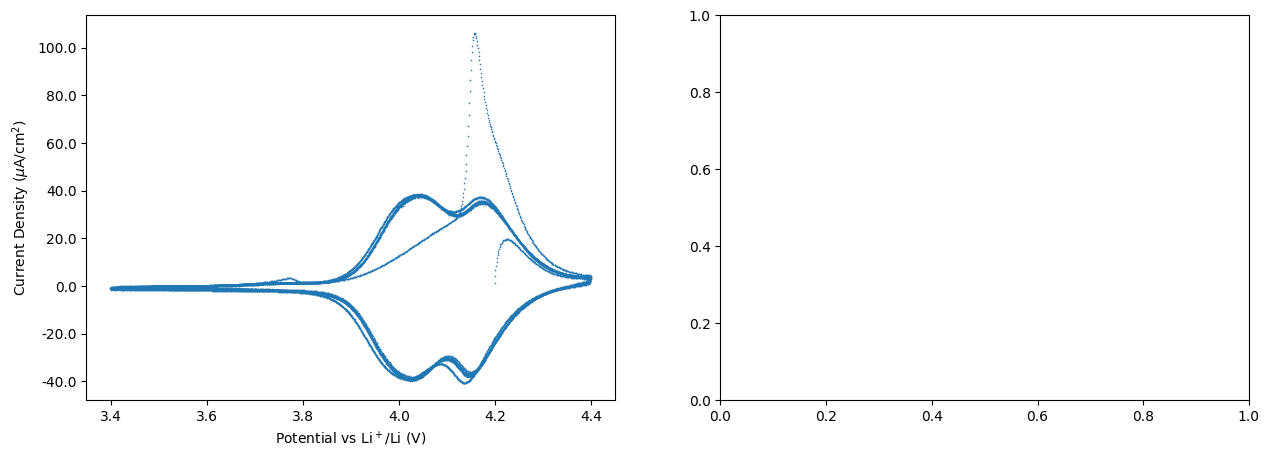

In [ ]:
# L20 TiO2 01 - LMO 2h std anneal with ALD TiO2. Thickness undetermined

path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L20\L20_TiO2_01'
# setup_files(path)
area = 3.1416 # cm2
thickness = 80 # nm
sample = 'LMO2h with ALD TiO2'
l20_tio2_01 = cc(path, area, thickness, sample)

# EIS
p = os.path.join(path, 'EIS\Relaxis')
l20_tio2_01_eis = eis(p, sample)
# l20_tio20_1_eis[0]


# Plots
fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = 100)
sns.scatterplot(data = l20_tio2_01[0], x = col_cv[0], y = col_cv[4], edgecolor = None, s =1, ax = ax[0])
ax[0].yaxis.set_major_formatter(formatter)

# sns.lineplot(data = l20_tio2_01[1], x = 'Capacity_calc', y = col_cv[0], hue = 'Cycle' )
# sns.lineplot(data = l20_tio2_01[2], x = 'Capacity_calc', y = col_cv[0], hue = 'Cycle', legend = False )

# fig, ax = plt.subplots(dpi = 100)
# sns.scatterplot(data = l20_tio2_01[3], x = 'Cycle', y = 'Capacity (mAh/cm$^3$)', hue = 'L/D' )

# fig, ax = plt.subplots(dpi = 200)
# sns.barplot(data = l20_tio2_01_eis[0], x = 'Potential vs Li$^+$/Li (V)', y = 'Charge Transfer Resistance ($\Omega$)', palette = 'cividis_r')

<AxesSubplot: xlabel='Potential vs Li$^+$/Li (V)', ylabel='Charge Transfer Resistance ($\\Omega$)'>

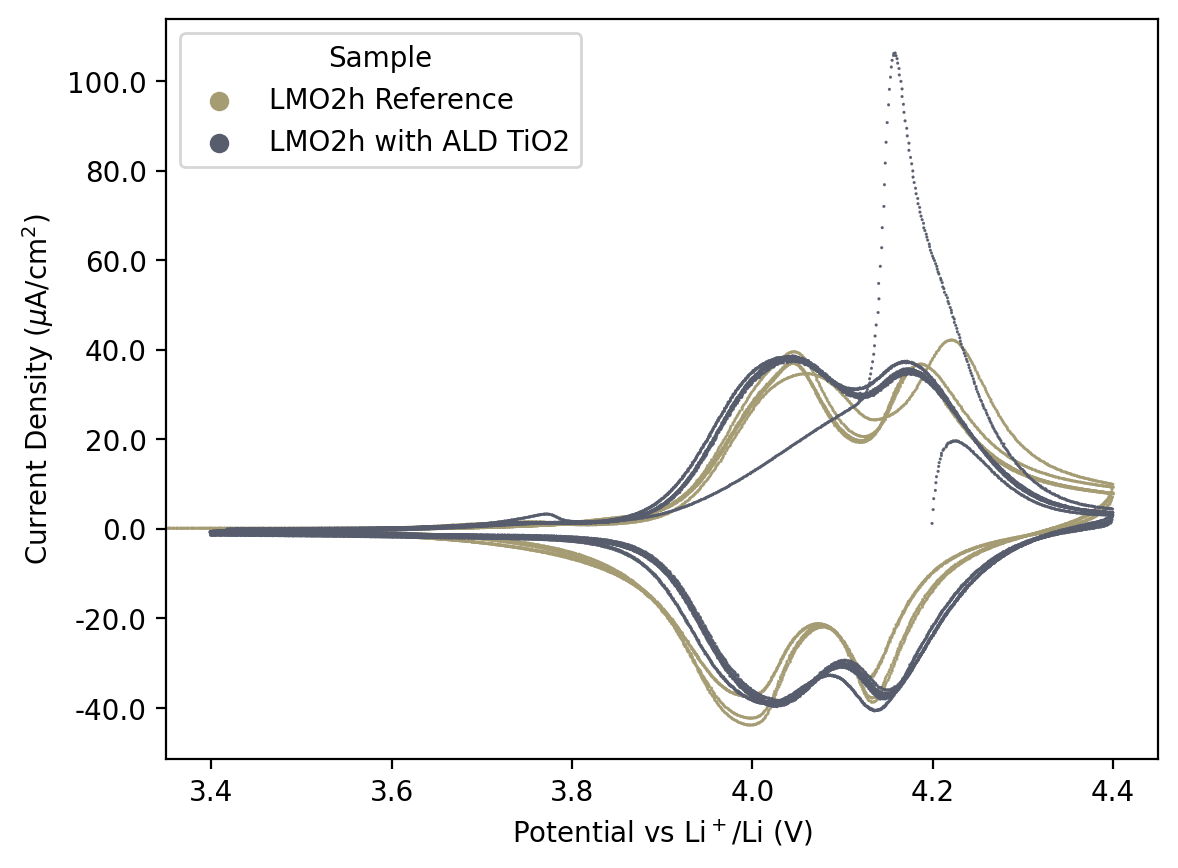

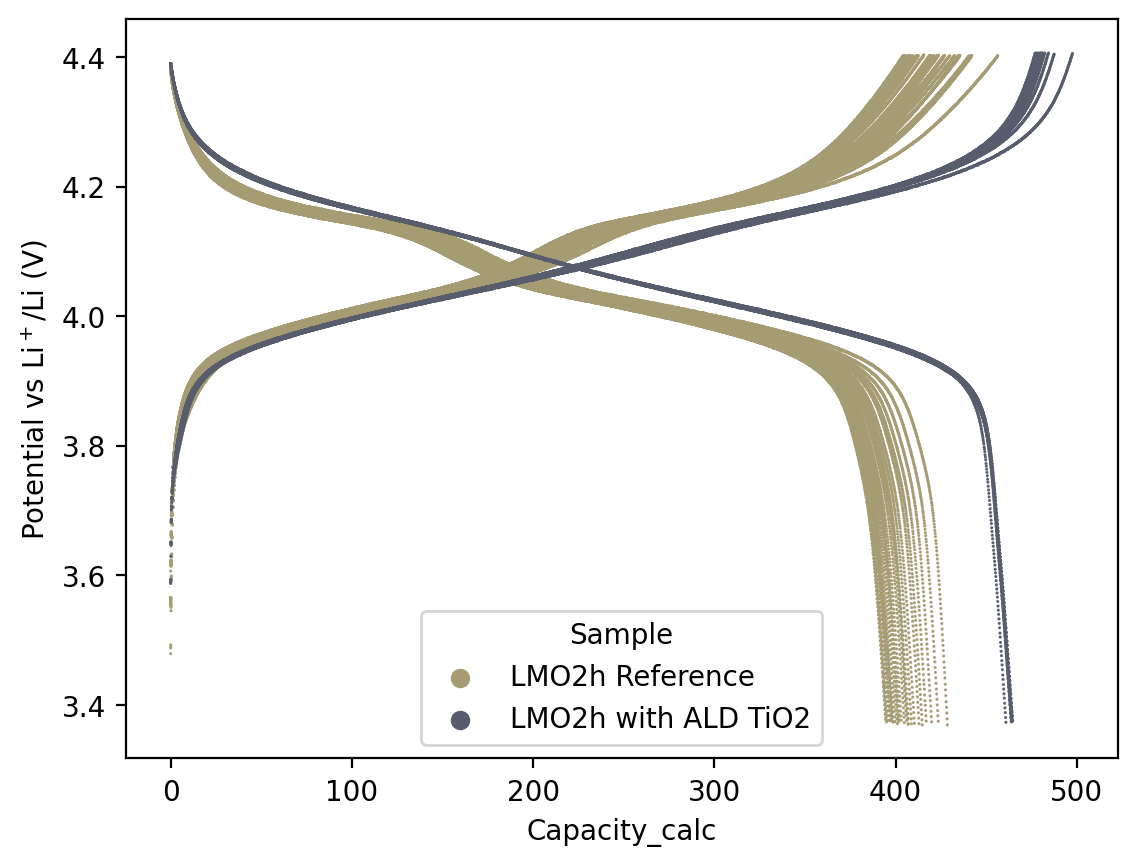

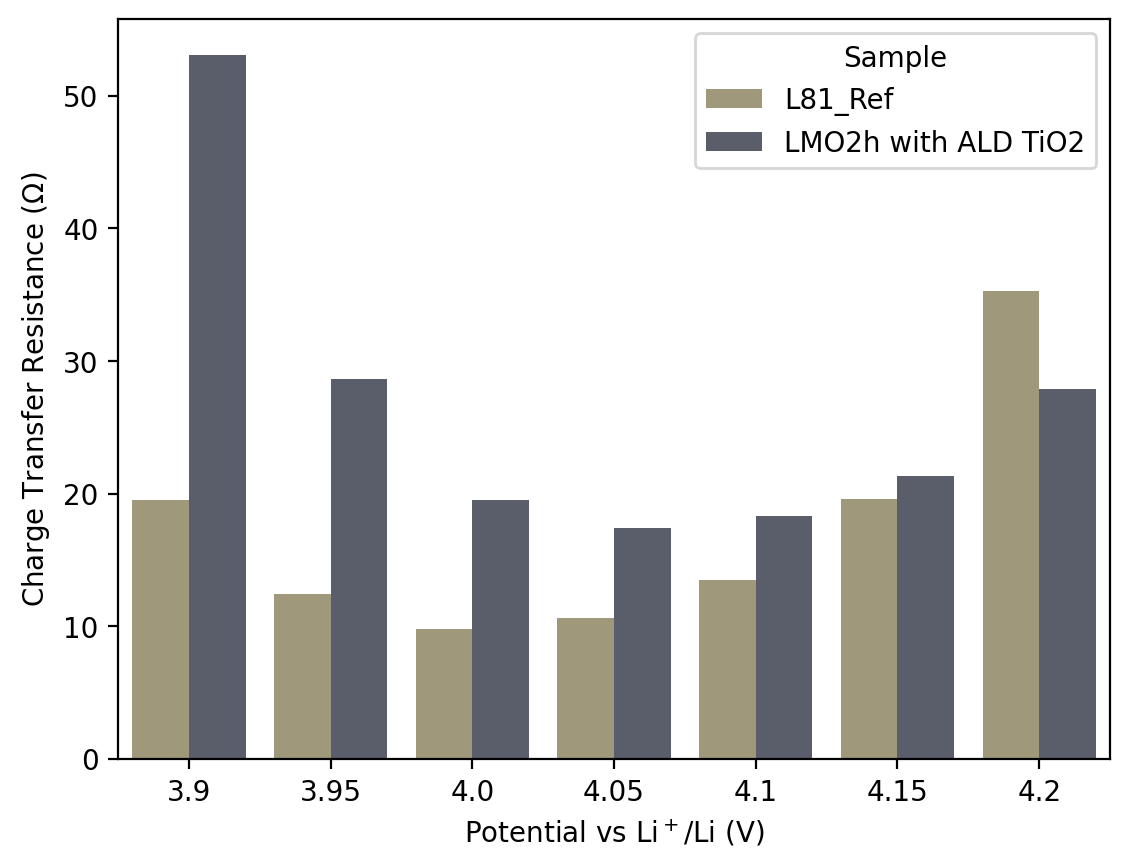

In [ ]:
# LMO 2h on Pt PLSA runs after changing Pt

results_6 # cv, l, d, c, e
results_6[0] = results_6[0].rename(columns={'WE(1).Potential (V)': col_cv[0], 'current_density (A/cm2)': col_cv[4]})
results_6[1] = results_6[1].rename(columns={'WE(1).Potential (V)': col_cv[0], 'Capacity (mAh/cm3)' : 'Capacity (mAh/cm$^3$)'})
results_6[2] = results_6[2].rename(columns={'WE(1).Potential (V)': col_cv[0], 'Capacity (mAh/cm3)' : 'Capacity (mAh/cm$^3$)'})

compare_cv = pd.concat([results_6[0], l20_tio2_01[0]], ignore_index=True)
compare_cc = pd.concat([results_6[1], results_6[2], l20_tio2_01[1], l20_tio2_01[2]], ignore_index=True)
compare_eis = pd.concat([ref_eis[0], l20_tio2_01_eis[0]], ignore_index=True)

#PLOT
fig, ax = plt.subplots(dpi = 200)
sns.scatterplot(data = compare_cv, x = col_cv[0], y = col_cv[4], hue = 'Sample', edgecolor = None, s =1, palette = 'cividis_r')
ax.yaxis.set_major_formatter(formatter)
plt.xlim(3.35, 4.45)

fig, ax = plt.subplots(dpi = 200)
sns.scatterplot(data = compare_cc, x = 'Capacity_calc', y = col_cv[0], hue = 'Sample', edgecolor = None, s =1, palette = 'cividis_r') #Capacity (mAh/cm$^3$)

fig, ax = plt.subplots(dpi = 200)
sns.barplot(data = compare_eis, x = 'Potential vs Li$^+$/Li (V)', y = 'Charge Transfer Resistance ($\Omega$)', hue = 'Sample', palette = 'cividis_r')
# results_6[1]
# l20_tio2_01[1]
# compare_eis

<AxesSubplot: xlabel='Cycle', ylabel='Capacity (mAh/cm$^3$)'>

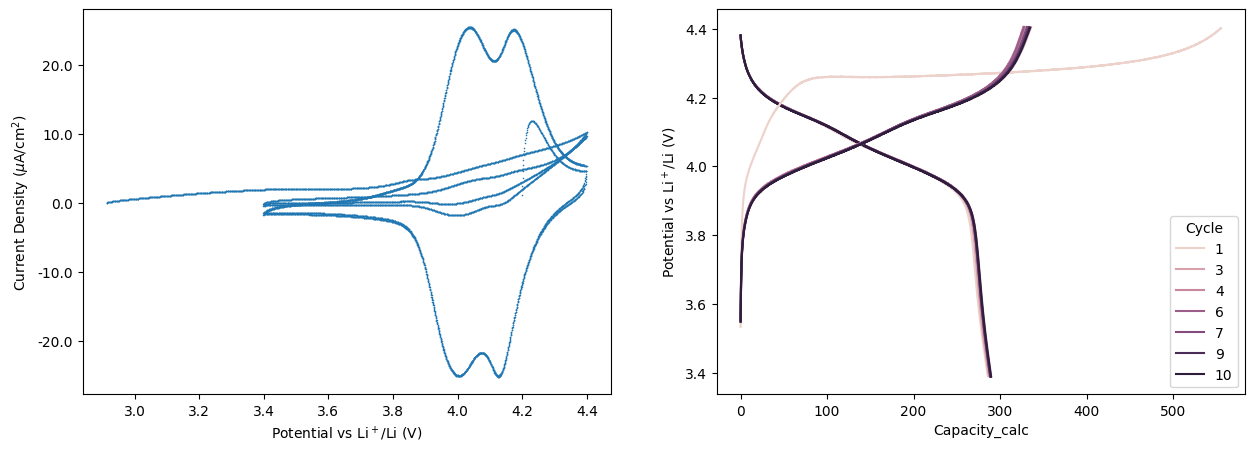

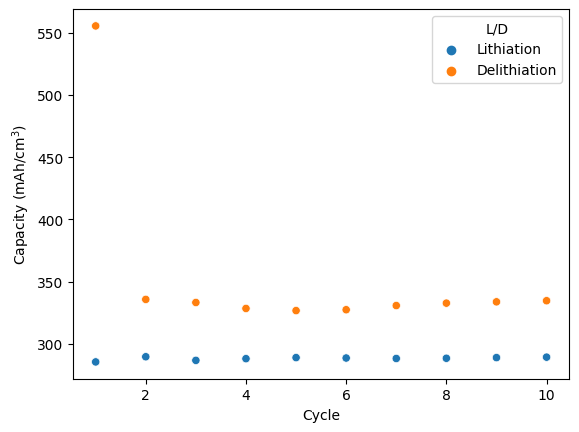

In [8]:
# L20_TiO2_N
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L20\L20_TiO2_N'
area = np.pi * 0.5**2  # cm2/
# setup_files(path)
thickness = 80 # nmk
sample = 'LMO2h with ALD TiO2 N'
l20_tio2_N = cc(path, area, thickness, sample)

# Plots
fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = 100)
sns.scatterplot(data = l20_tio2_N[0], x = col_cv[0], y = col_cv[4], edgecolor = None, s =1, ax = ax[0])
ax[0].yaxis.set_major_formatter(formatter)

sns.lineplot(data = l20_tio2_N[1], x = 'Capacity_calc', y = col_cv[0], hue = 'Cycle' )
sns.lineplot(data = l20_tio2_N[2], x = 'Capacity_calc', y = col_cv[0], hue = 'Cycle', legend = False )

fig, ax = plt.subplots(dpi = 100)
sns.scatterplot(data = l20_tio2_N[3], x = 'Cycle', y = 'Capacity (mAh/cm$^3$)', hue = 'L/D' )

<AxesSubplot: xlabel='Cycle', ylabel='Capacity (mAh/cm$^3$)'>

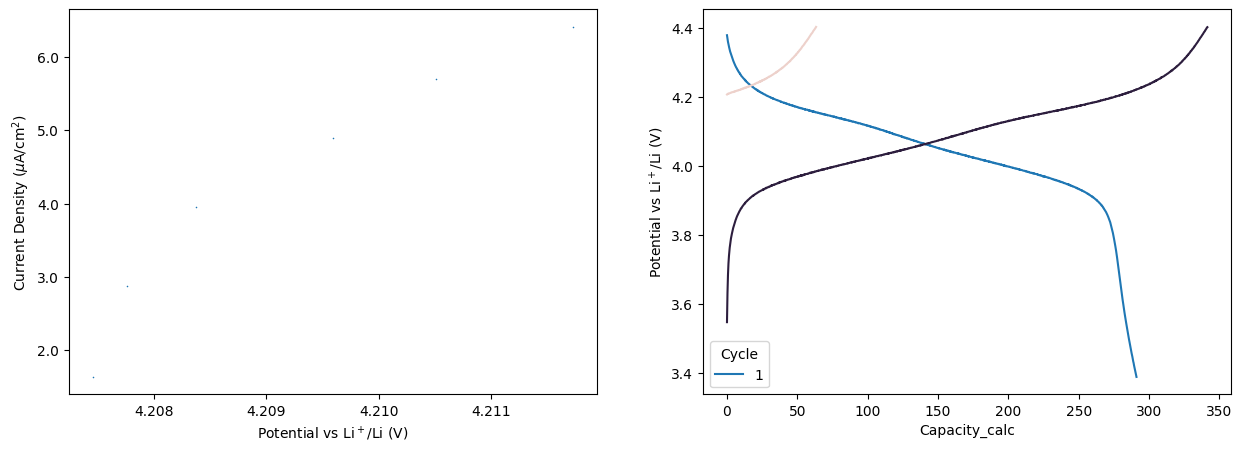

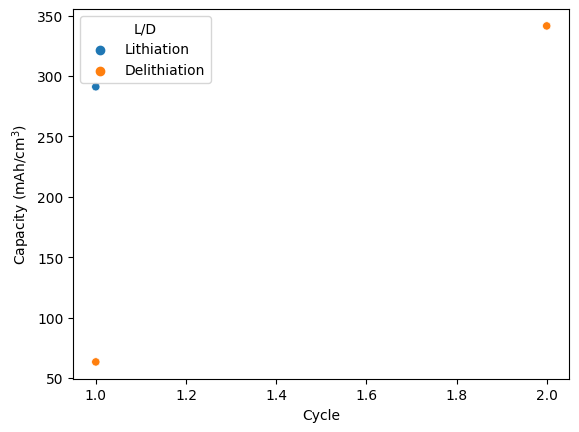

In [9]:
# L20_TiO2_N
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L20\L20_TiO2_N_R2'
area = np.pi * 0.5**2  # cm2/
setup_files(path)
thickness = 80 # nmk
sample = 'LMO2h with ALD TiO2 N2'
l20_tio2_N2 = cc(path, area, thickness, sample)

# Plots
fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = 100)
sns.scatterplot(data = l20_tio2_N2[0], x = col_cv[0], y = col_cv[4], edgecolor = None, s =1, ax = ax[0])
ax[0].yaxis.set_major_formatter(formatter)

sns.lineplot(data = l20_tio2_N2[1], x = 'Capacity_calc', y = col_cv[0], hue = 'Cycle' )
sns.lineplot(data = l20_tio2_N2[2], x = 'Capacity_calc', y = col_cv[0], hue = 'Cycle', legend = False )

fig, ax = plt.subplots(dpi = 100)
sns.scatterplot(data = l20_tio2_N2[3], x = 'Cycle', y = 'Capacity (mAh/cm$^3$)', hue = 'L/D' )

<AxesSubplot: xlabel='Cycle', ylabel='Capacity (mAh/cm$^3$)'>

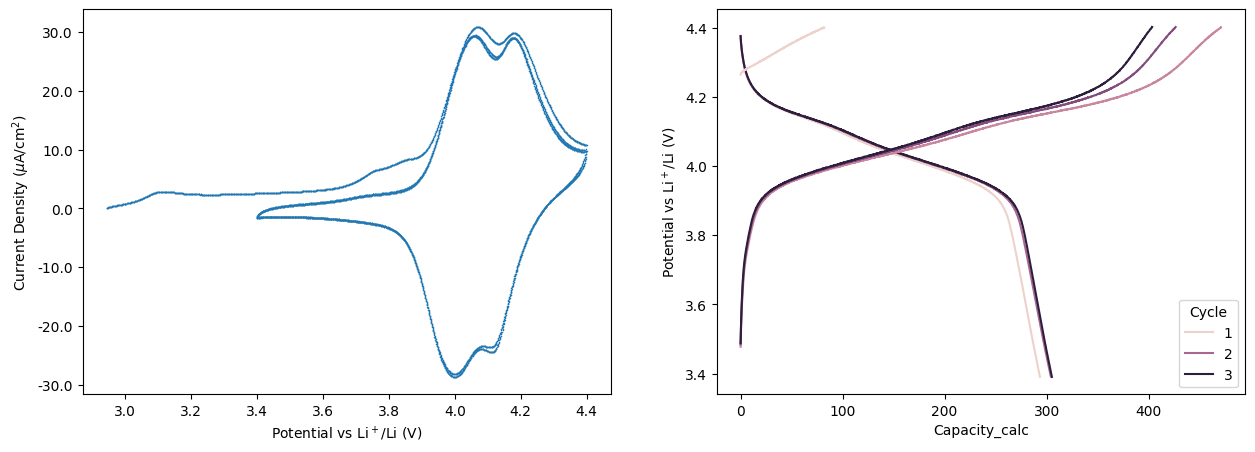

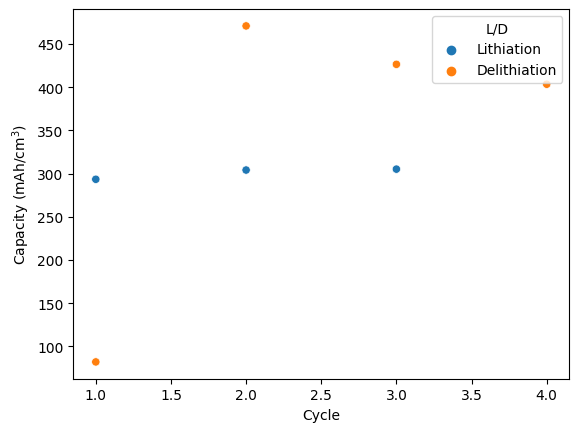

In [10]:
# L20_TiO2_FL
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L20\L20_TiO2_FL'
area = np.pi * 0.5**2  # cm2/
setup_files(path)
thickness = 80 # nmk
sample = 'LMO2h with ALD TiO2 FL'
l20_tio2_FL = cc(path, area, thickness, sample)

# Plots
fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = 100)
sns.scatterplot(data = l20_tio2_FL[0], x = col_cv[0], y = col_cv[4], edgecolor = None, s =1, ax = ax[0])
ax[0].yaxis.set_major_formatter(formatter)

sns.lineplot(data = l20_tio2_FL[1], x = 'Capacity_calc', y = col_cv[0], hue = 'Cycle' )
sns.lineplot(data = l20_tio2_FL[2], x = 'Capacity_calc', y = col_cv[0], hue = 'Cycle', legend = False )

fig, ax = plt.subplots(dpi = 100)
sns.scatterplot(data = l20_tio2_FL[3], x = 'Cycle', y = 'Capacity (mAh/cm$^3$)', hue = 'L/D' )

Text(0.5, 0, 'Capacity (mAh/cm$^3$)')

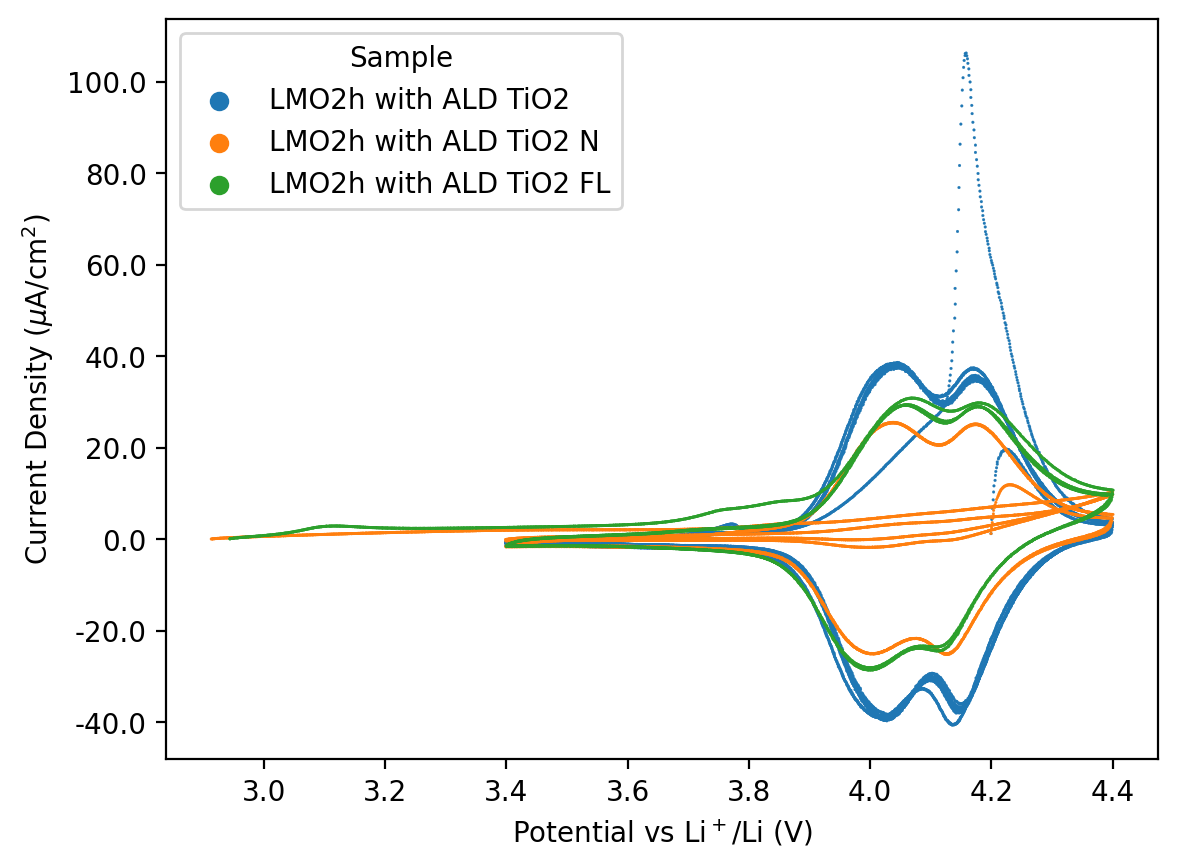

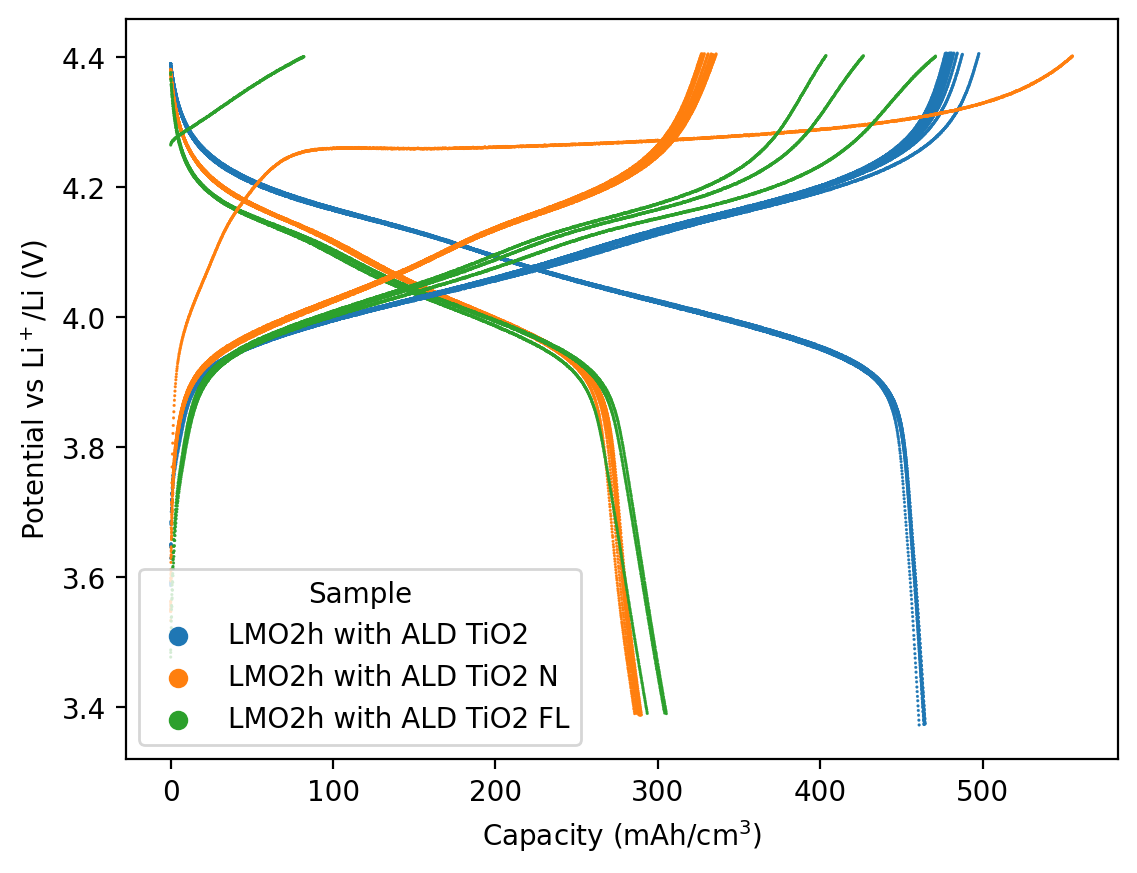

In [11]:
# Comparison
samples_cv = pd.concat([l20_tio2_01[0], l20_tio2_N[0], l20_tio2_FL[0]], ignore_index=True) #results_6
sample_l = pd.concat([l20_tio2_01[1], l20_tio2_N[1], l20_tio2_FL[1]], ignore_index=True)
sample_d = pd.concat([l20_tio2_01[2], l20_tio2_N[2], l20_tio2_FL[2]], ignore_index=True)
# PLots
fig, ax = plt.subplots(dpi = 200)
sns.scatterplot(data = samples_cv, x = col_cv[0], y = col_cv[4], edgecolor = None, s =1, hue = 'Sample')
ax.yaxis.set_major_formatter(formatter)

fig, ax = plt.subplots(dpi = 200)
sns.scatterplot(data = sample_l, x = 'Capacity_calc', y = col_cv[0], hue = 'Sample', edgecolor = None, s =1 )
sns.scatterplot(data = sample_d, x = 'Capacity_calc', y = col_cv[0], hue = 'Sample', legend = False, edgecolor = None, s =1 )
plt.xlabel('Capacity (mAh/cm$^3$)')
